In [1]:
import pandas as pd 
import nltk
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec




1. Data Analysis

In [2]:
df = pd.read_csv("data/train.csv") 
print(df.head())

sum_of_0 = (df['Sentiment'] == 0).sum()
sum_of_1 = (df['Sentiment'] == 1).sum()

print("\nTotal entries with a positve sentiment: ", sum_of_1)
print("Total entries with a negative sentiment: ", sum_of_0)

print(df.isna().sum())
test = pd.read_csv('data/test.csv')
print(test.head())

sum_of_0_test = (test['Sentiment'] == 0).sum()
sum_of_1_test = (test['Sentiment'] == 1).sum()

print("\nTotal test entries with a positve sentiment: ", sum_of_1_test)
print("Total test entries with a negative sentiment: ", sum_of_0_test)





   Index  Sentiment                                               Text
0      0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1      1          0  is upset that he can't update his Facebook by ...
2      2          0  @Kenichan I dived many times for the ball. Man...
3      3          0    my whole body feels itchy and like its on fire 
4      4          0  @nationwideclass no, it's not behaving at all....

Total entries with a positve sentiment:  248575
Total entries with a negative sentiment:  800000
Index        0
Sentiment    0
Text         0
dtype: int64
   Index  Sentiment                                               Text
0      0          1  @stellargirl I loooooooovvvvvveee my Kindle2. ...
1      1          1  Reading my kindle2...  Love it... Lee childs i...
2      2          1  Ok, first assesment of the #kindle2 ...it fuck...
3      3          1  @kenburbary You'll love your Kindle2. I've had...
4      4          1  @mikefish  Fair enough. But i have the Kin

2. Data Preprocessing

In [3]:
combined_df = pd.concat([df, test], axis = 0, ignore_index=True)

# all lower case

combined_df['Text'] = combined_df['Text'].str.lower()
print("Finished changing all letters to lower case")



Finished changing all letters to lower case


In [4]:
# remove special chars and numbers 
for i in range(len(combined_df['Text'])):
    # reomve special chars
    sentence = re.sub('[^\w\s]', '', str(combined_df.loc[i,'Text']))
    sentence = re.sub(r'\d+', '', sentence)
    combined_df.loc[i,'Text'] = sentence
    

print('Finished removing special characters and digital numbers')
   
   

Finished removing special characters and digital numbers


In [12]:
#tokenization 
#from nltk.tokenize import sent_tokenize

#sentence = sent_tokenize(str(combined_df.loc[0, 'Text']))

# for i in range(len(combined_df['Text'])):
#     sentence = sent_tokenize(combined_df.loc[i, 'Text'])
#     combined_df.loc[i,'Text'] = sentence

3. Feautre Extraction

In [6]:
# use 10% of the data 
preproccessed_test = combined_df.iloc[len(df):]
preproccessed_train = combined_df.iloc[:len(df)]

preproccessed_test = preproccessed_test.reset_index(drop=True)

print(preproccessed_train.head())
print(preproccessed_test.head())

random_sample_train_df = preproccessed_train.sample(frac=0.01, random_state=42)

   Index  Sentiment                                               Text
0      0          0  switchfoot httptwitpiccomyzl  awww thats a bum...
1      1          0  is upset that he cant update his facebook by t...
2      2          0  kenichan i dived many times for the ball manag...
3      3          0    my whole body feels itchy and like its on fire 
4      4          0  nationwideclass no its not behaving at all im ...
   Index  Sentiment                                               Text
0      0          1  stellargirl i loooooooovvvvvveee my kindle not...
1      1          1  reading my kindle  love it lee childs is good ...
2      2          1  ok first assesment of the kindle it fucking rocks
3      3          1  kenburbary youll love your kindle ive had mine...
4      4          1  mikefish  fair enough but i have the kindle an...


In [7]:
# bag of words
from sklearn.feature_extraction.text import CountVectorizer

bow_vecotizer = CountVectorizer()

bag_of_words_train = bow_vecotizer.fit_transform(random_sample_train_df['Text'])
bag_of_words_test = bow_vecotizer.transform(preproccessed_test['Text'])
bag_of_words_df_train = pd.DataFrame(bag_of_words_train.toarray())
print(bag_of_words_df_train.head())


   0      1      2      3      4      5      6      7      8      9      ...  \
0      0      0      0      0      0      0      0      0      0      0  ...   
1      0      0      0      0      0      0      0      0      0      0  ...   
2      0      0      0      0      0      0      0      0      0      0  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4      0      0      0      0      0      0      0      0      0      0  ...   

   19344  19345  19346  19347  19348  19349  19350  19351  19352  19353  
0      0      0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0      0      0  

[5 rows x 19354 columns]


In [8]:
#tf * idf
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer()

tf_idf_features = tf_idf_vect.fit_transform(random_sample_train_df['Text'])
tf_idf_test = tf_idf_vect.transform(preproccessed_test['Text'])
tf_idf_array = tf_idf_features.toarray()



In [13]:
#word2vec

# word2vec_model_train = Word2Vec(preproccessed_train['Text'], size=100, window=5, min_count=1)
# word2vec_model_test = Word2Vec(preproccessed_test['Text'], size=100, window=5, min_count=1)

sentences = [sentence.split() for sentence in random_sample_train_df['Text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

# Vectorize the text data
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

word2vec_train = np.array([vectorize(sentence) for sentence in random_sample_train_df['Text']])
word2vec_test = np.array([vectorize(sentence) for sentence in preproccessed_test['Text']])

4. Model Training

c:\Users\alecr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


finsihed logistic
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       177
           1       0.74      0.72      0.73       182

    accuracy                           0.73       359
   macro avg       0.73      0.73      0.73       359
weighted avg       0.73      0.73      0.73       359

finsihed gauss
finsihed rand forest
              precision    recall  f1-score   support

           0       0.58      0.76      0.66       177
           1       0.67      0.47      0.55       182

    accuracy                           0.61       359
   macro avg       0.63      0.61      0.61       359
weighted avg       0.63      0.61      0.60       359

              precision    recall  f1-score   support

           0       0.58      0.77      0.66       177
           1       0.67      0.47      0.55       182

    accuracy                           0.62       359
   macro avg       0.63      0.62      0.61       359
weighted avg       0

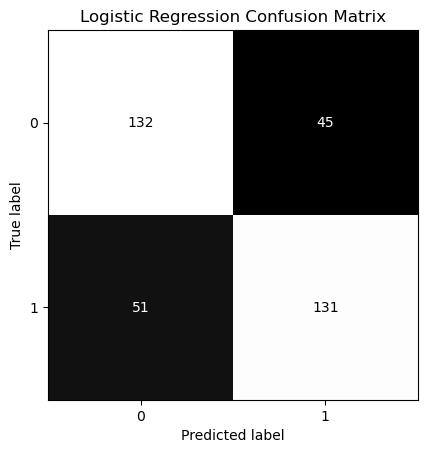

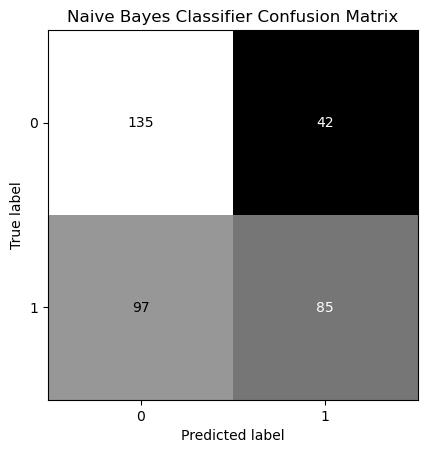

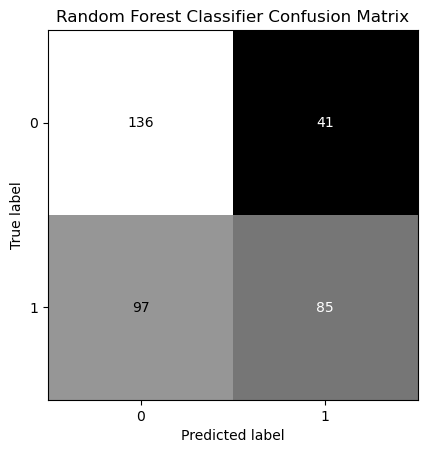

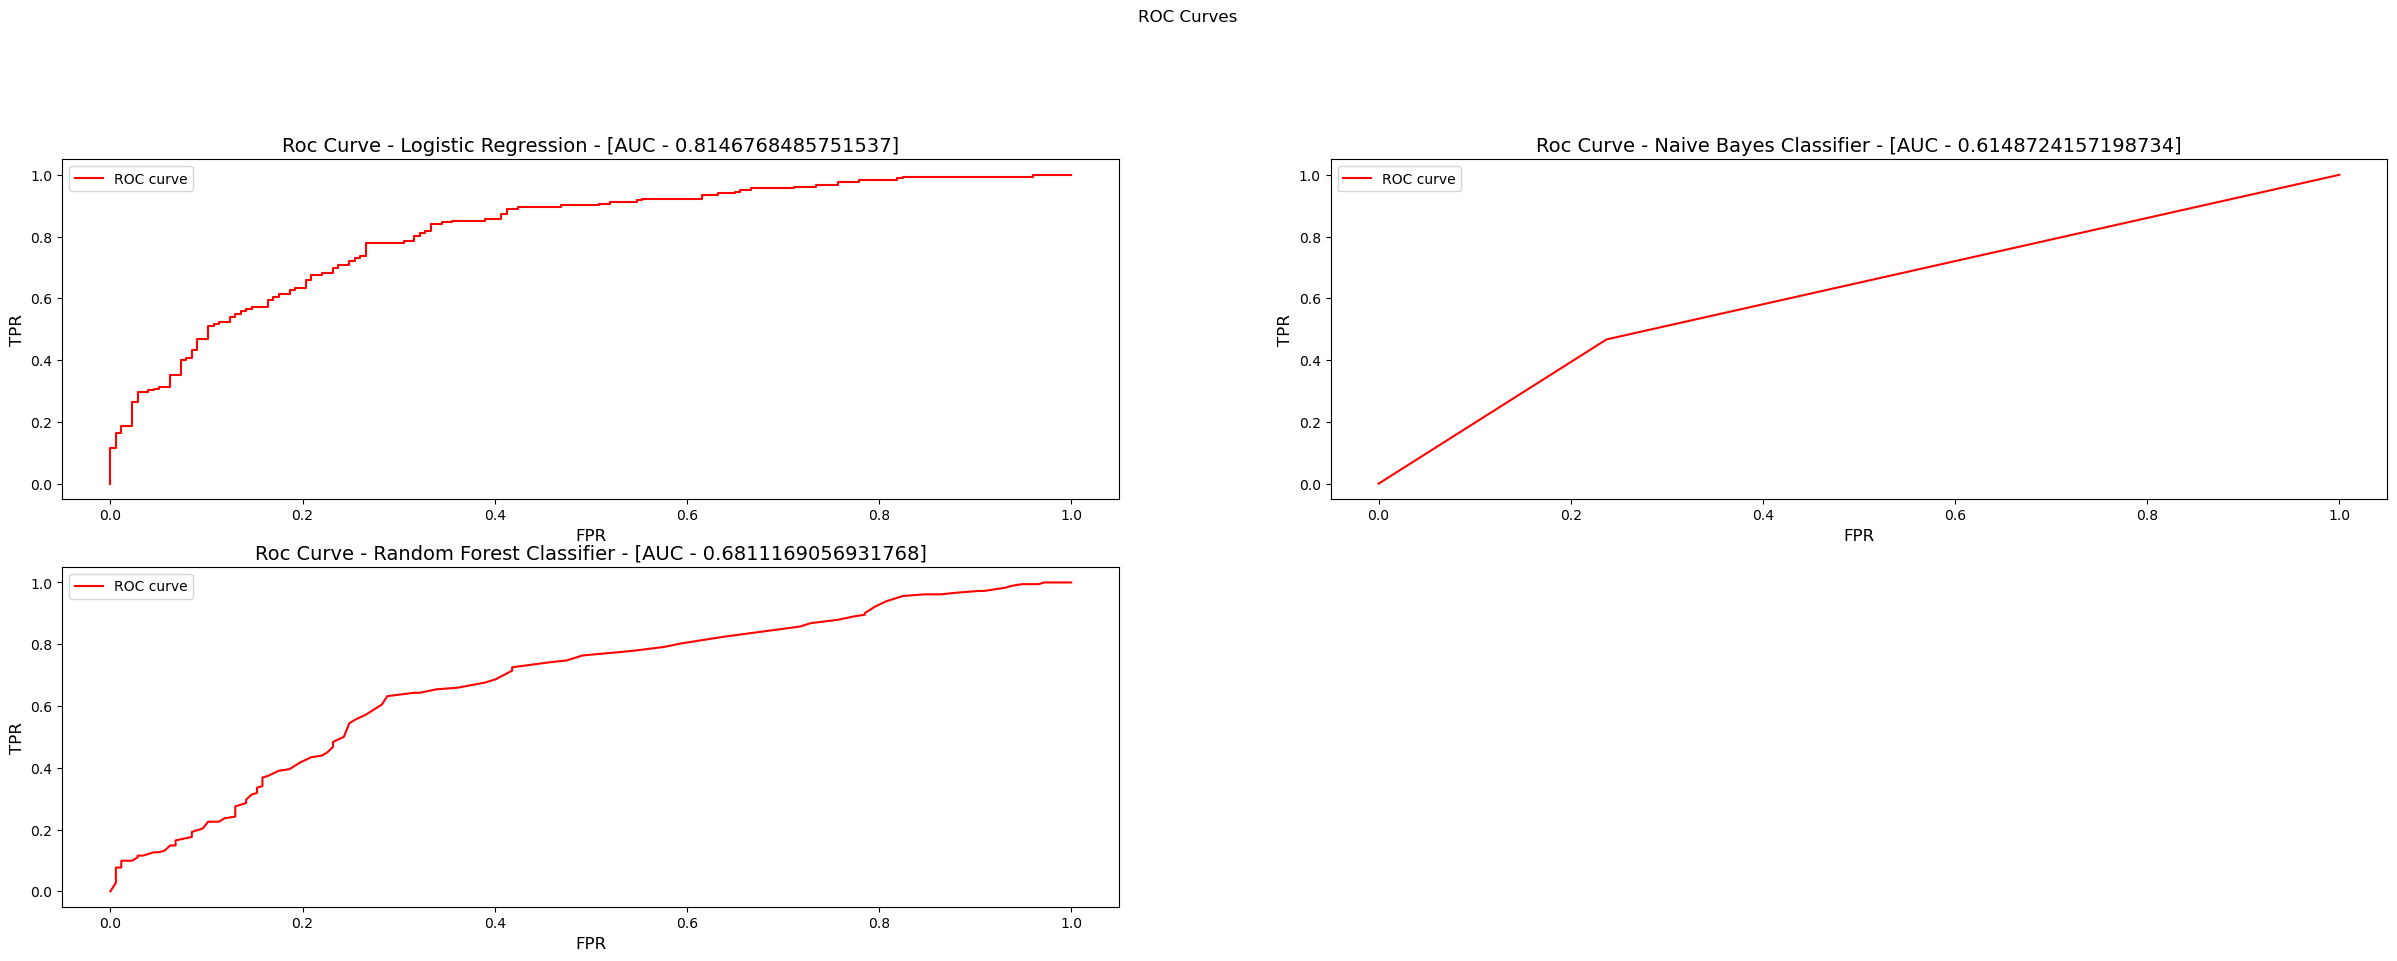

In [10]:
#bag of words training
logisticBOW = LogisticRegression()
gaussBOW = GaussianNB()
randomForestBOW = RandomForestClassifier()

x = bag_of_words_train.toarray()
y = random_sample_train_df['Sentiment']
xTest = pd.DataFrame(bag_of_words_test.toarray())
yTest = preproccessed_test['Sentiment']

oversample = SMOTE()
smote_xTrain, smote_yTrain = oversample.fit_resample(x, y)

logisticBOW.fit(smote_xTrain, smote_yTrain)
print("finsihed logistic")
yLogisticPredicted = logisticBOW.predict(xTest)
yLogisticPredProba = logisticBOW.predict_proba(xTest)
print(classification_report(yTest, yLogisticPredicted))

gaussBOW.fit(smote_xTrain, smote_yTrain)
print("finsihed gauss")
randomForestBOW.fit(smote_xTrain, smote_yTrain)
print("finsihed rand forest")



yGaussPredicted = gaussBOW.predict(xTest)
yGaussPredProba = gaussBOW.predict_proba(xTest)

yRandomForestPredicted = randomForestBOW.predict(xTest)
yRandomForestPredProba = randomForestBOW.predict_proba(xTest)

# display F1 scores and accuracy 


print(classification_report(yTest, yGaussPredicted))
print(classification_report(yTest, yRandomForestPredicted))

models = ['Logistic Regression', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions = [yLogisticPredicted, yGaussPredicted, yRandomForestPredicted]
pred_probabilities = [yLogisticPredProba,  yGaussPredProba, yRandomForestPredProba]

# Display confusion matrices
for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(yTest.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

# Displays ROC and AUC value
for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(yTest, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()


finsihed logistic
finsihed gauss
finsihed rand forest
              precision    recall  f1-score   support

           0       0.73      0.82      0.77       177
           1       0.80      0.70      0.75       182

    accuracy                           0.76       359
   macro avg       0.76      0.76      0.76       359
weighted avg       0.76      0.76      0.76       359

              precision    recall  f1-score   support

           0       0.58      0.77      0.66       177
           1       0.67      0.45      0.54       182

    accuracy                           0.61       359
   macro avg       0.63      0.61      0.60       359
weighted avg       0.63      0.61      0.60       359

              precision    recall  f1-score   support

           0       0.55      0.94      0.70       177
           1       0.81      0.26      0.40       182

    accuracy                           0.60       359
   macro avg       0.68      0.60      0.55       359
weighted avg       0

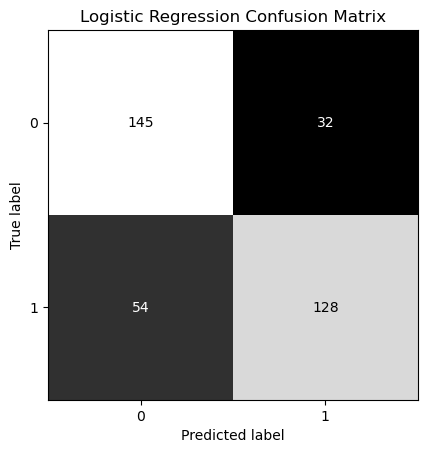

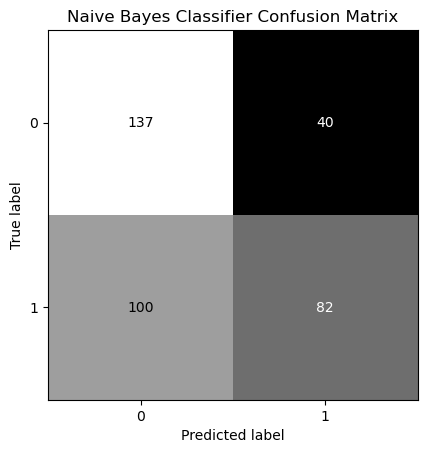

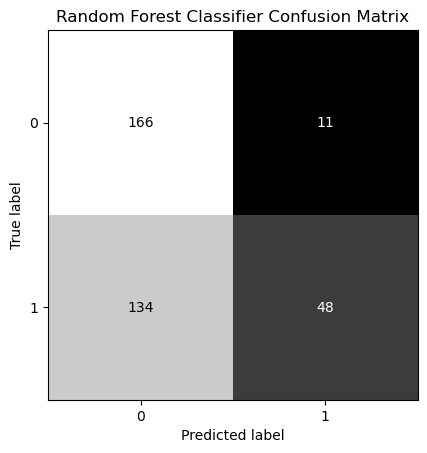

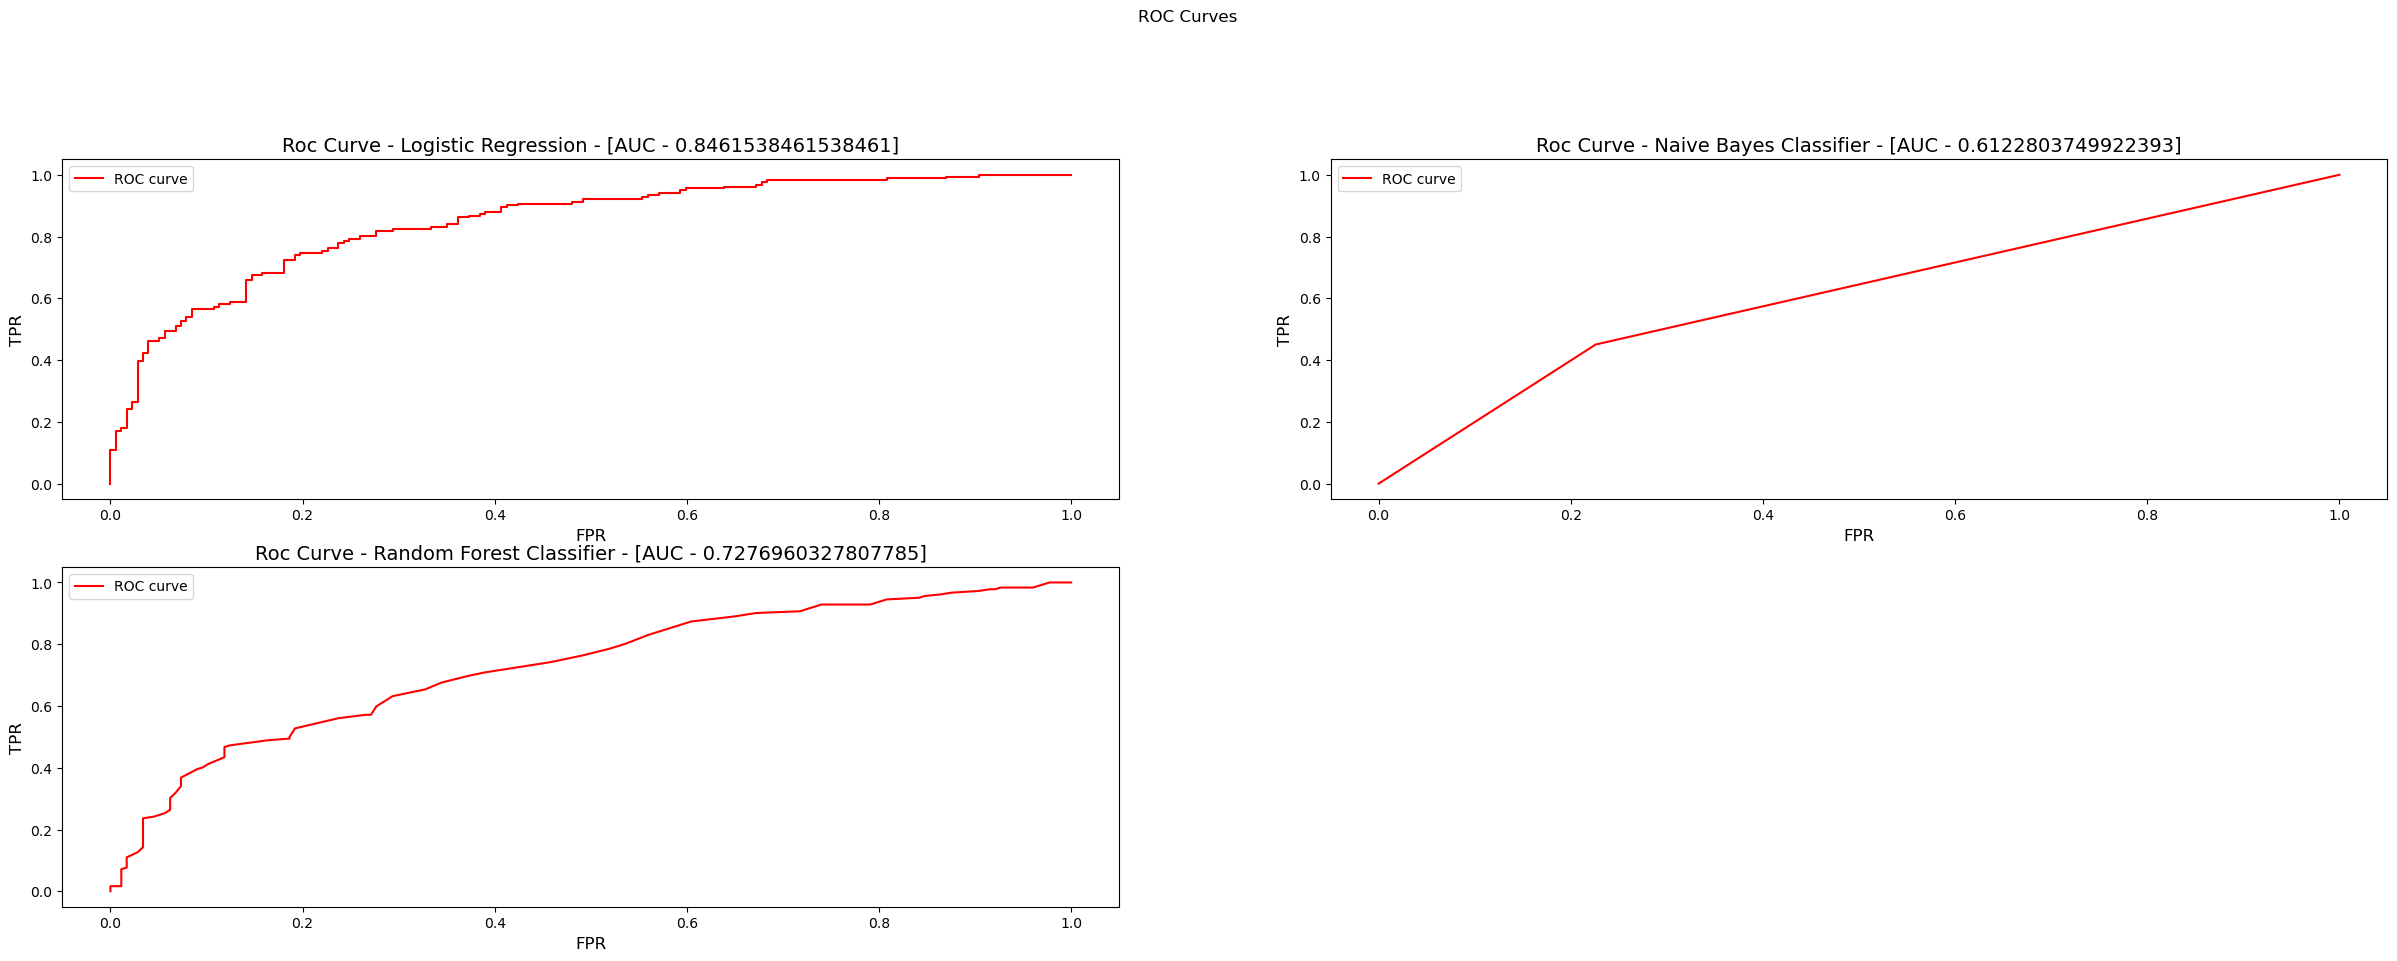

In [16]:
#td * idf 
logistic_tf_idf = LogisticRegression()
gauss_tf_idf = GaussianNB()
randomForest_tf_idf = RandomForestClassifier()


x = tf_idf_array
y = random_sample_train_df['Sentiment']

xTest = tf_idf_test.toarray()
yTest = preproccessed_test['Sentiment']

oversample = SMOTE()
smote_xTrain, smote_yTrain = oversample.fit_resample(x, y)

logistic_tf_idf.fit(smote_xTrain, smote_yTrain)
print("finsihed logistic")

gauss_tf_idf.fit(smote_xTrain, smote_yTrain)
print("finsihed gauss")
randomForest_tf_idf.fit(smote_xTrain, smote_yTrain)
print("finsihed rand forest")

yLogisticPredicted = logistic_tf_idf.predict(xTest)
yLogisticPredProba = logistic_tf_idf.predict_proba(xTest)

yGaussPredicted = gauss_tf_idf.predict(xTest)
yGaussPredProba = gauss_tf_idf.predict_proba(xTest)

yRandomForestPredicted = randomForest_tf_idf.predict(xTest)
yRandomForestPredProba = randomForest_tf_idf.predict_proba(xTest)

# display F1 scores and accuracy 
print(classification_report(yTest, yLogisticPredicted))
print(classification_report(yTest, yGaussPredicted))
print(classification_report(yTest, yRandomForestPredicted))

models = ['Logistic Regression', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions = [yLogisticPredicted, yGaussPredicted, yRandomForestPredicted]
pred_probabilities = [yLogisticPredProba, yGaussPredProba, yRandomForestPredProba]

# Display confusion matrices
for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(yTest.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

# Displays ROC and AUC value
for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(yTest, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()



c:\Users\alecr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


finsihed logistic
finsihed gauss
finsihed rand forest
              precision    recall  f1-score   support

           0       0.58      0.46      0.51       177
           1       0.56      0.68      0.61       182

    accuracy                           0.57       359
   macro avg       0.57      0.57      0.56       359
weighted avg       0.57      0.57      0.56       359

              precision    recall  f1-score   support

           0       0.52      0.74      0.61       177
           1       0.56      0.32      0.41       182

    accuracy                           0.53       359
   macro avg       0.54      0.53      0.51       359
weighted avg       0.54      0.53      0.51       359

              precision    recall  f1-score   support

           0       0.52      0.81      0.63       177
           1       0.60      0.27      0.38       182

    accuracy                           0.54       359
   macro avg       0.56      0.54      0.50       359
weighted avg       0

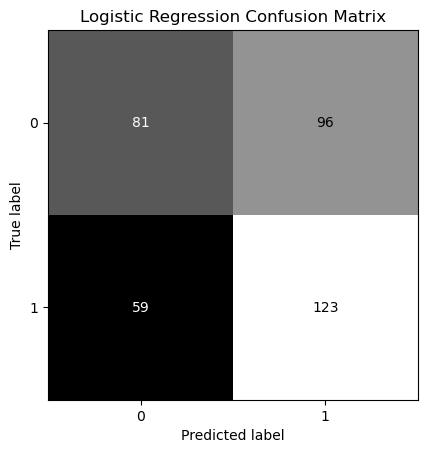

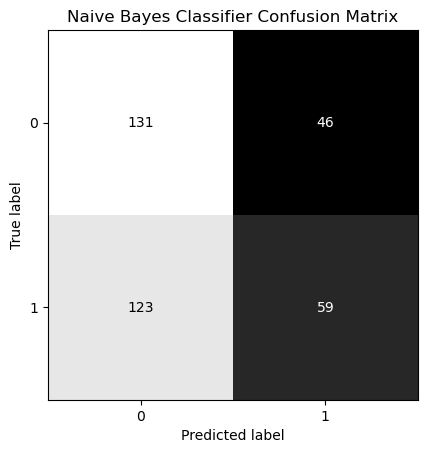

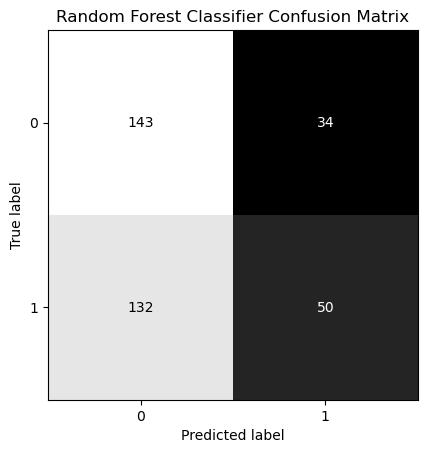

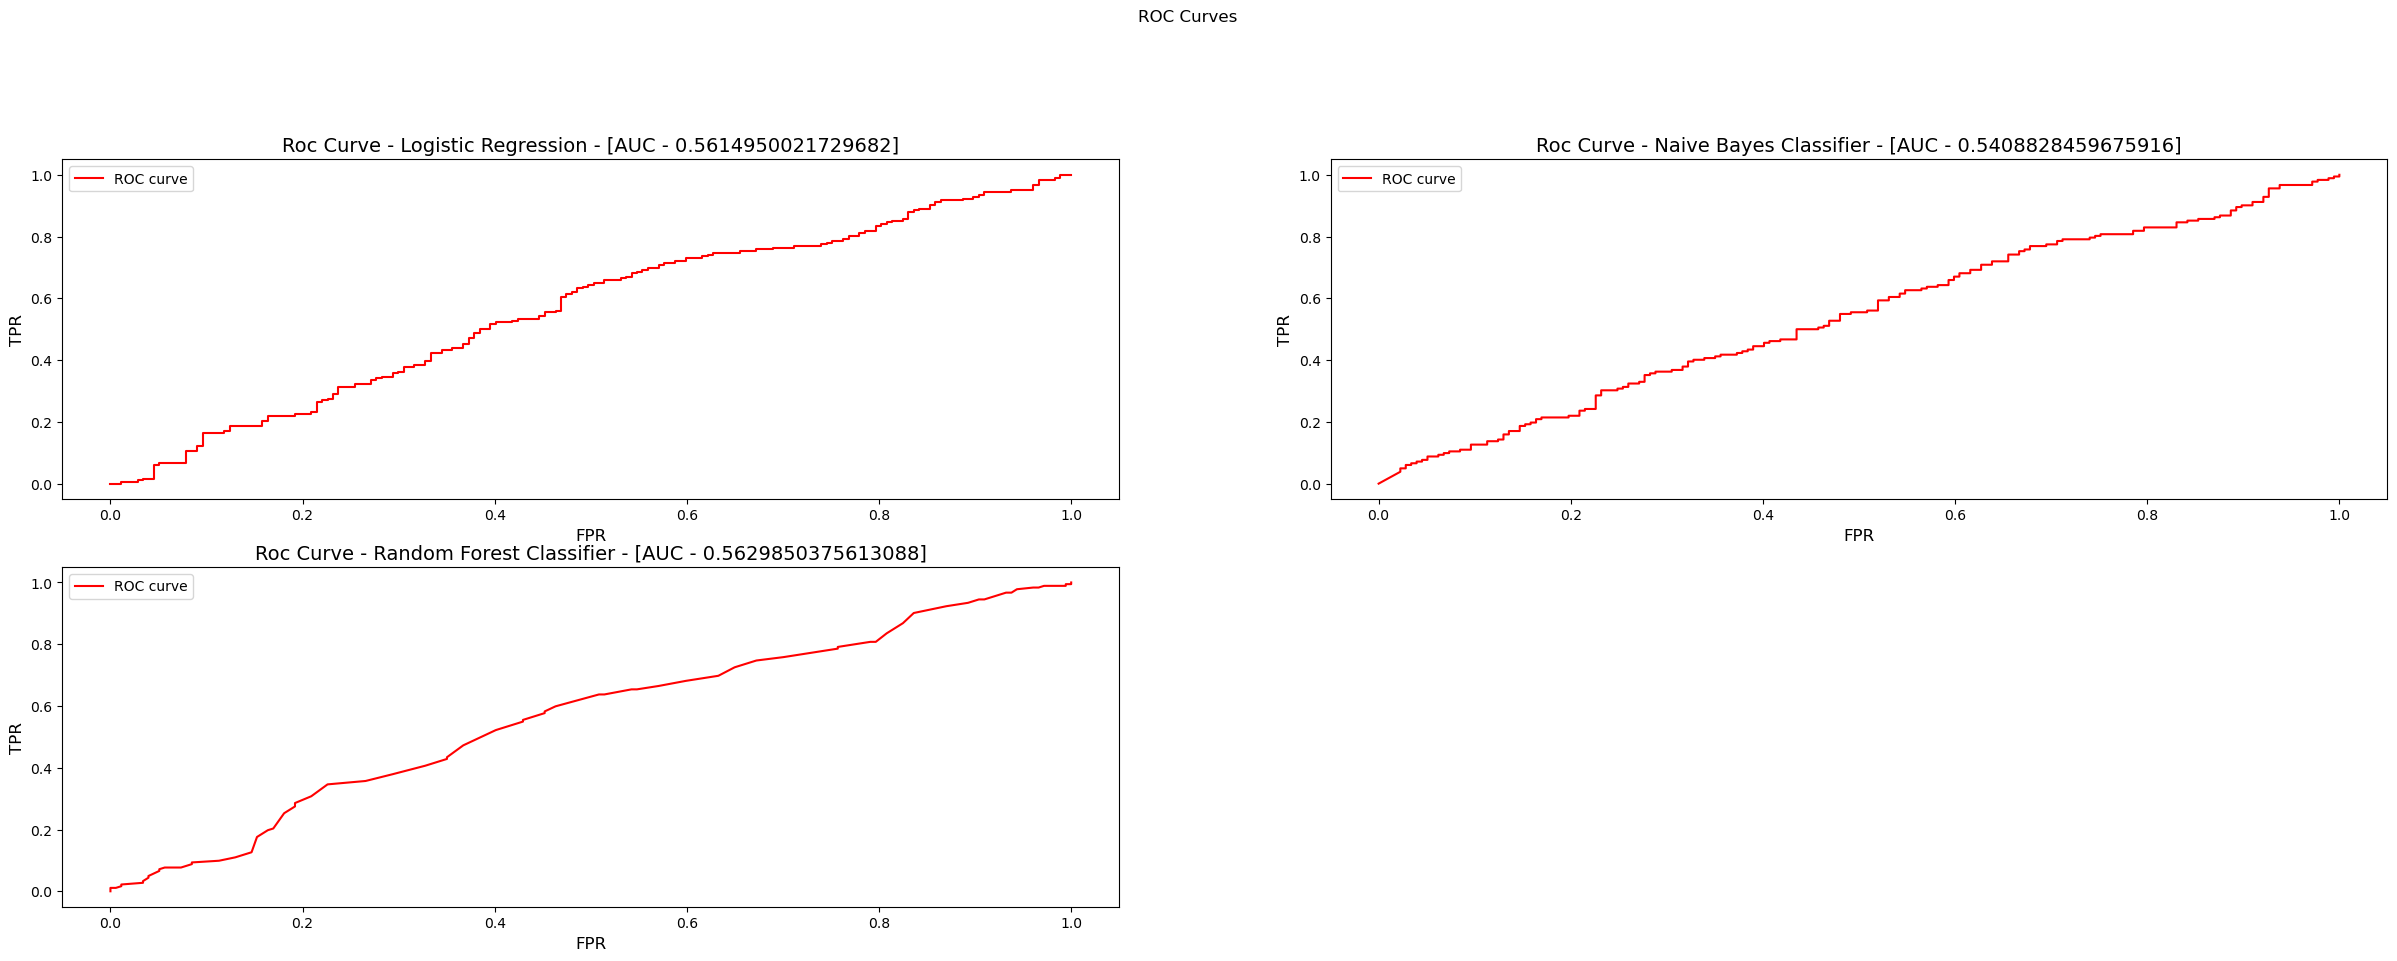

In [18]:
#word2vec
logistic_word2vec = LogisticRegression()
gauss_word2vec = GaussianNB()
randomForest_word2vec = RandomForestClassifier()


x = word2vec_train
y = random_sample_train_df['Sentiment']

xTest = word2vec_test
yTest = preproccessed_test['Sentiment']

oversample = SMOTE()
smote_xTrain, smote_yTrain = oversample.fit_resample(x, y)

logistic_word2vec.fit(smote_xTrain, smote_yTrain)
print("finsihed logistic")
gauss_word2vec.fit(smote_xTrain, smote_yTrain)
print("finsihed gauss")
randomForest_word2vec.fit(smote_xTrain, smote_yTrain)
print("finsihed rand forest")

yLogisticPredicted = logistic_word2vec.predict(xTest)
yLogisticPredProba = logistic_word2vec.predict_proba(xTest)

yGaussPredicted = gauss_word2vec.predict(xTest)
yGaussPredProba = gauss_word2vec.predict_proba(xTest)

yRandomForestPredicted = randomForest_word2vec.predict(xTest)
yRandomForestPredProba = randomForest_word2vec.predict_proba(xTest)

# display F1 scores and accuracy 
print(classification_report(yTest, yLogisticPredicted))
print(classification_report(yTest, yGaussPredicted))
print(classification_report(yTest, yRandomForestPredicted))

models = ['Logistic Regression', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions = [yLogisticPredicted, yGaussPredicted, yRandomForestPredicted]
pred_probabilities = [yLogisticPredProba, yGaussPredProba, yRandomForestPredProba]

# Display confusion matrices
for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(yTest.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

# Displays ROC and AUC value
for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(yTest, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()

